In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, countDistinct
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder.appName("EDA_Silver").getOrCreate()
LAKEHOUSE_BRZ = "lh_bronze"
LAKEHOUSE_SLV = "lh_silver"

print("🔍 EDA SILVER - Análisis Bronze vs Silver")
print("="*70)

StatementMeta(, 7f716a5f-ac0c-4c6f-a69e-198749a6dfb7, 3, Finished, Available, Finished)

🔍 EDA SILVER - Análisis Bronze vs Silver


In [2]:
# ============================================
# 1. Comparación Tabla por Tabla
# ============================================
tables_brz = spark.sql(f"SHOW TABLES IN {LAKEHOUSE_BRZ}").filter(
    col("tableName").startswith("brz_redata_") & 
    col("tableName").endswith("_month")
).select("tableName").collect()

comparisons = []

for row in tables_brz:
    brz_table = row.tableName
    slv_table = brz_table.replace("brz_", "slv_")
    
    # Leer tablas
    df_brz = spark.table(f"{LAKEHOUSE_BRZ}.{brz_table}")
    df_slv = spark.table(f"{LAKEHOUSE_SLV}.{slv_table}")
    
    # Claves de negocio
    if "balance_electrico" in brz_table:
        keys = ["geo_id", "datetime", "series_type", "metric_type"]
    else:
        keys = ["geo_id", "datetime", "series_type"]
    
    # Métricas Bronze
    brz_count = df_brz.count()
    brz_dups = df_brz.groupBy(keys).agg(count("*").alias("n")).filter(col("n") > 1).count()
    brz_cols = len(df_brz.columns)
    
    # Métricas Silver
    slv_count = df_slv.count()
    slv_dups = df_slv.groupBy(keys).agg(count("*").alias("n")).filter(col("n") > 1).count()
    slv_cols = len(df_slv.columns)
    
    # Calcular mejoras
    removed = brz_count - slv_count
    cols_dropped = brz_cols - slv_cols
    
    comparisons.append({
        "tabla": brz_table.replace("brz_redata_", ""),
        "brz_registros": brz_count,
        "slv_registros": slv_count,
        "eliminados": removed,
        "reduccion_pct": (removed / brz_count * 100) if brz_count > 0 else 0,
        "brz_dups": brz_dups,
        "slv_dups": slv_dups,
        "brz_cols": brz_cols,
        "slv_cols": slv_cols,
        "cols_dropped": cols_dropped
    })

df_comp = pd.DataFrame(comparisons)

StatementMeta(, 7f716a5f-ac0c-4c6f-a69e-198749a6dfb7, 4, Finished, Available, Finished)

StatementMeta(, 7f716a5f-ac0c-4c6f-a69e-198749a6dfb7, 5, Finished, Available, Finished)

/tmp/ipykernel_10382/2985452507.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/IPython/core/pylabt

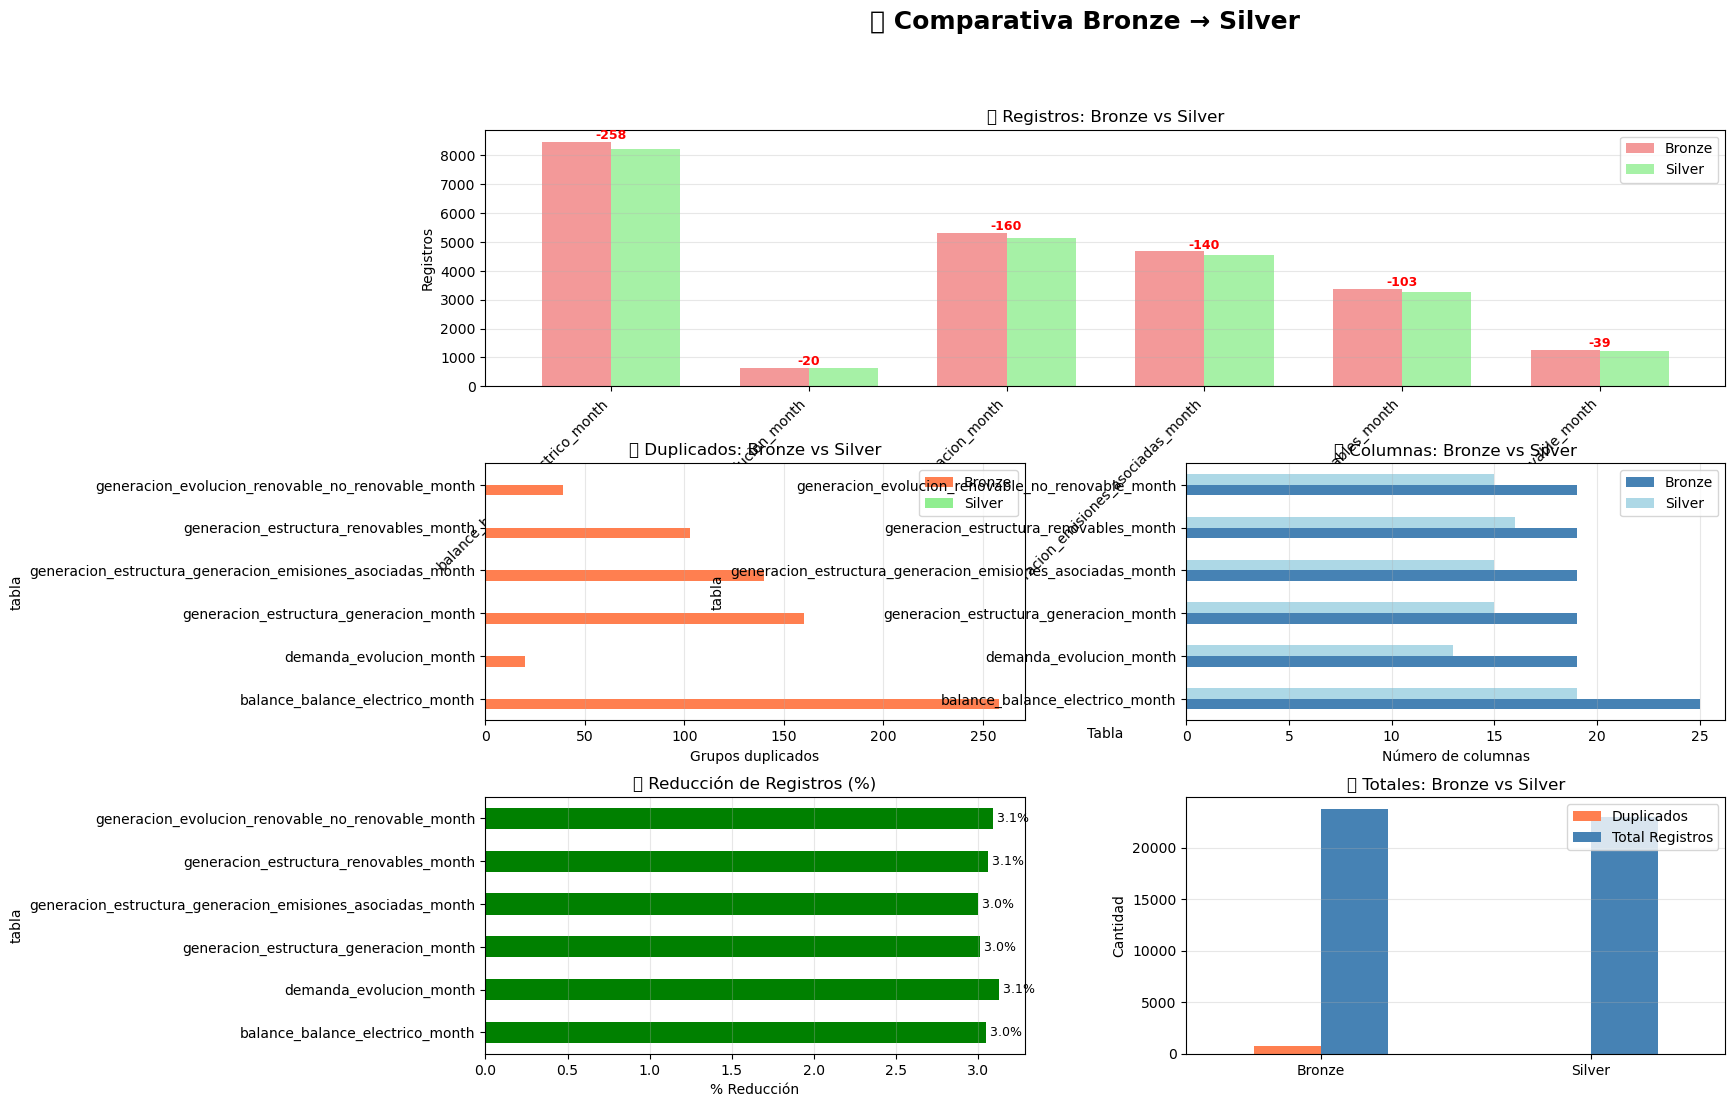

In [3]:
# ============================================
# 2. Visualización Comparativa
# ============================================

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

fig.suptitle('📊 Comparativa Bronze → Silver', fontsize=18, fontweight='bold')

# 2.1 Registros: Before/After
ax1 = fig.add_subplot(gs[0, :])
x = range(len(df_comp))
width = 0.35
ax1.bar([i - width/2 for i in x], df_comp['brz_registros'], width, 
        label='Bronze', color='lightcoral', alpha=0.8)
ax1.bar([i + width/2 for i in x], df_comp['slv_registros'], width, 
        label='Silver', color='lightgreen', alpha=0.8)
ax1.set_xlabel('Tabla')
ax1.set_ylabel('Registros')
ax1.set_title('📈 Registros: Bronze vs Silver')
ax1.set_xticks(x)
ax1.set_xticklabels(df_comp['tabla'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Añadir etiquetas de reducción
for i, row in df_comp.iterrows():
    if row['eliminados'] > 0:
        ax1.text(i, row['brz_registros'], f"-{row['eliminados']}", 
                ha='center', va='bottom', fontsize=9, color='red', fontweight='bold')

# 2.2 Duplicados eliminados
ax2 = fig.add_subplot(gs[1, 0])
df_comp.plot(x='tabla', y=['brz_dups', 'slv_dups'], kind='barh', ax=ax2, 
             color=['coral', 'lightgreen'])
ax2.set_title('🔁 Duplicados: Bronze vs Silver')
ax2.set_xlabel('Grupos duplicados')
ax2.legend(['Bronze', 'Silver'])
ax2.grid(axis='x', alpha=0.3)

# 2.3 Columnas eliminadas
ax3 = fig.add_subplot(gs[1, 1])
df_comp.plot(x='tabla', y=['brz_cols', 'slv_cols'], kind='barh', ax=ax3,
             color=['steelblue', 'lightblue'])
ax3.set_title('📋 Columnas: Bronze vs Silver')
ax3.set_xlabel('Número de columnas')
ax3.legend(['Bronze', 'Silver'])
ax3.grid(axis='x', alpha=0.3)

# 2.4 Porcentaje de reducción
ax4 = fig.add_subplot(gs[2, 0])
colors = ['green' if x > 0 else 'gray' for x in df_comp['reduccion_pct']]
df_comp.plot(x='tabla', y='reduccion_pct', kind='barh', ax=ax4, color=colors, legend=False)
ax4.set_title('📉 Reducción de Registros (%)')
ax4.set_xlabel('% Reducción')
for i, v in enumerate(df_comp['reduccion_pct']):
    if v > 0:
        ax4.text(v, i, f' {v:.1f}%', va='center', fontsize=9)
ax4.grid(axis='x', alpha=0.3)

# 2.5 Métricas de calidad
ax5 = fig.add_subplot(gs[2, 1])
quality_metrics = pd.DataFrame({
    'Bronze': [
        df_comp['brz_dups'].sum(),
        df_comp['brz_registros'].sum()
    ],
    'Silver': [
        df_comp['slv_dups'].sum(),
        df_comp['slv_registros'].sum()
    ]
}, index=['Duplicados', 'Total Registros'])

quality_metrics.T.plot(kind='bar', ax=ax5, color=['coral', 'steelblue'])
ax5.set_title('📊 Totales: Bronze vs Silver')
ax5.set_ylabel('Cantidad')
ax5.set_xticklabels(['Bronze', 'Silver'], rotation=0)
ax5.legend(loc='upper right')
ax5.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
# ============================================
# 3. Resumen Ejecutivo
# ============================================
print("\n" + "="*70)
print("📊 RESUMEN DE TRANSFORMACIÓN")
print("="*70)

total_brz = df_comp['brz_registros'].sum()
total_slv = df_comp['slv_registros'].sum()
total_removed = df_comp['eliminados'].sum()
total_dups_removed = df_comp['brz_dups'].sum() - df_comp['slv_dups'].sum()

print(f"\n📈 REGISTROS:")
print(f"   Bronze:    {total_brz:,}")
print(f"   Silver:    {total_slv:,}")
print(f"   Eliminados: {total_removed:,} ({(total_removed/total_brz*100):.1f}%)")

print(f"\n🔁 DUPLICADOS:")
print(f"   Bronze:    {df_comp['brz_dups'].sum():,} grupos")
print(f"   Silver:    {df_comp['slv_dups'].sum():,} grupos")
print(f"   Eliminados: {total_dups_removed:,} grupos")

if df_comp['slv_dups'].sum() == 0:
    print(f"   ✅ PERFECTO: Sin duplicados en Silver")
else:
    print(f"   ⚠️  ADVERTENCIA: {df_comp['slv_dups'].sum()} duplicados remanentes")

print(f"\n📋 COLUMNAS:")
avg_cols_dropped = df_comp['cols_dropped'].mean()
print(f"   Promedio eliminadas: {avg_cols_dropped:.1f} por tabla")
print(f"   Total eliminadas: {df_comp['cols_dropped'].sum()}")

StatementMeta(, 7f716a5f-ac0c-4c6f-a69e-198749a6dfb7, 6, Finished, Available, Finished)


📊 RESUMEN DE TRANSFORMACIÓN

📈 REGISTROS:
   Bronze:    23,712
   Silver:    22,992
   Eliminados: 720 (3.0%)

🔁 DUPLICADOS:
   Bronze:    720 grupos
   Silver:    0 grupos
   Eliminados: 720 grupos
   ✅ PERFECTO: Sin duplicados en Silver

📋 COLUMNAS:
   Promedio eliminadas: 4.5 por tabla
   Total eliminadas: 27


In [5]:
# ============================================
# 4. Verificación de Calidad
# ============================================
print("\n" + "="*70)
print("✅ VERIFICACIÓN DE CALIDAD")
print("="*70)

all_clean = True

for _, row in df_comp.iterrows():
    print(f"\n📦 {row['tabla']}:")
    
    checks = []
    if row['slv_dups'] == 0:
        checks.append("✅ Sin duplicados")
    else:
        checks.append(f"⚠️  {row['slv_dups']} duplicados")
        all_clean = False
    
    if row['eliminados'] > 0:
        checks.append(f"✅ {row['eliminados']} registros limpiados")
    
    if row['cols_dropped'] > 0:
        checks.append(f"✅ {row['cols_dropped']} columnas eliminadas")
    
    print("   " + " | ".join(checks))

print("\n" + "="*70)
if all_clean:
    print("🎉 TODAS LAS TABLAS PASARON LA VERIFICACIÓN")
else:
    print("⚠️  REVISAR TABLAS CON DUPLICADOS REMANENTES")
print("="*70)

StatementMeta(, 7f716a5f-ac0c-4c6f-a69e-198749a6dfb7, 7, Finished, Available, Finished)


✅ VERIFICACIÓN DE CALIDAD

📦 balance_balance_electrico_month:
   ✅ Sin duplicados | ✅ 258 registros limpiados | ✅ 6 columnas eliminadas

📦 demanda_evolucion_month:
   ✅ Sin duplicados | ✅ 20 registros limpiados | ✅ 6 columnas eliminadas

📦 generacion_estructura_generacion_month:
   ✅ Sin duplicados | ✅ 160 registros limpiados | ✅ 4 columnas eliminadas

📦 generacion_estructura_generacion_emisiones_asociadas_month:
   ✅ Sin duplicados | ✅ 140 registros limpiados | ✅ 4 columnas eliminadas

📦 generacion_estructura_renovables_month:
   ✅ Sin duplicados | ✅ 103 registros limpiados | ✅ 3 columnas eliminadas

📦 generacion_evolucion_renovable_no_renovable_month:
   ✅ Sin duplicados | ✅ 39 registros limpiados | ✅ 4 columnas eliminadas

🎉 TODAS LAS TABLAS PASARON LA VERIFICACIÓN


In [6]:
# ============================================
# 5. Ejemplo: Verificar Limpieza
# ============================================
print("\n" + "="*70)
print("🔍 EJEMPLO: Verificación de Limpieza")
print("="*70)

# Tomar tabla con más duplicados eliminados
max_reduction = df_comp.loc[df_comp['eliminados'].idxmax()]
table_name = max_reduction['tabla']

print(f"\n📦 Tabla con mayor limpieza: {table_name}")
print(f"   Eliminados: {max_reduction['eliminados']} registros")
print(f"   Reducción: {max_reduction['reduccion_pct']:.1f}%")

brz_table = f"brz_redata_{table_name}"
slv_table = f"slv_redata_{table_name}"

df_brz = spark.table(f"{LAKEHOUSE_BRZ}.{brz_table}")
df_slv = spark.table(f"{LAKEHOUSE_SLV}.{slv_table}")

print(f"\n📊 Distribución por región (geo_id):")
print("\nBRONZE:")
df_brz.groupBy("geo_id").count().orderBy("count", ascending=False).show(5)
print("SILVER:")
df_slv.groupBy("geo_id").count().orderBy("count", ascending=False).show(5)

print("\n✅ EDA Silver completado")
print("\n💡 PRÓXIMO PASO: Usar tablas Silver para capa Gold y dashboards")

StatementMeta(, 7f716a5f-ac0c-4c6f-a69e-198749a6dfb7, 8, Finished, Available, Finished)


🔍 EJEMPLO: Verificación de Limpieza

📦 Tabla con mayor limpieza: balance_balance_electrico_month
   Eliminados: 258 registros
   Reducción: 3.0%

📊 Distribución por región (geo_id):

BRONZE:
+------+-----+
|geo_id|count|
+------+-----+
|  8741|  739|
|     9|  527|
|     7|  518|
|    15|  500|
|  8743|  497|
+------+-----+
only showing top 5 rows

SILVER:
+------+-----+
|geo_id|count|
+------+-----+
|  8741|  720|
|     9|  510|
|     7|  501|
|  8743|  484|
|    15|  484|
+------+-----+
only showing top 5 rows


✅ EDA Silver completado

💡 PRÓXIMO PASO: Usar tablas Silver para capa Gold y dashboards
